# Coursework 2: Fish Classification

Created by Athanasios Vlontzos and Wenjia Bai

In this coursework, you will be exploring the application of convolutional neural networks for image classification tasks. As opposed to standard applications such as object or face classification, we will be dealing with a slightly different domain, fish classification for precision fishing.

In precision fishing, engineers and fishmen collaborate to extract a wide variety of information about the fish, their species and wellbeing etc. using data from satellite images to drones surveying the fisheries. The goal of precision fishing is to provide the marine industry with information to support their decision making processes.

Here your will develop an image classification model that can classify fish species given input images. It consists of two tasks. The first task is to train a model for the following species:
- Black Sea Sprat
- Gilt-Head Bream
- Shrimp
- Striped Red Mullet
- Trout

The second task is to finetune the last layer of the trained model to adapt to some new species, including:
- Hourse Mackerel
- Red Mullet
- Red Sea Bream
- Sea Bass

You will be working using a large-scale fish dataset [1].

[1] O. Ulucan, D. Karakaya and M. Turkan. A large-scale dataset for fish segmentation and classification. Innovations in Intelligent Systems and Applications Conference (ASYU). 2020.

## Step 0: Download data.

[Download the Data from here -- make sure you access it with your Imperial account.](https://imperiallondon-my.sharepoint.com/:f:/g/personal/av2514_ic_ac_uk/EkA9HyXVvgdFoLI4P_IfO1cBO_CsvY1KN4NE8iuD-s_VlA?e=Ip03rF)

It is a ~2.5GB file. You can save the images and annotations directories in the same directory as this notebook or somewhere else.

The fish dataset contains 9 species of fishes. There are 1,000 images for each fish species, named as %05d.png in each subdirectory.

## Step 1: Load the data. (15 Points)

- Complete the dataset class with the skeleton below.
- Add any transforms you feel are necessary.

Your class should have at least 3 elements
- An ```__init__``` function that sets up your class and all the necessary parameters.
- An ```__len__``` function that returns the size of your dataset.
- An ```__getitem__``` function that given an index within the limits of the size of the dataset returns the associated image and label in tensor form.

You may add more helper functions if you want.

In this section we are following the Pytorch [dataset](https://pytorch.org/vision/stable/datasets.html) class structure. You can take inspiration from their documentation.

In [1]:
# Dependencies
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets
import os
from PIL import Image
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import glob
import seaborn
import torchvision

In [2]:
# We will start by building a dataset class using the following 5 species of fishes
Multiclass_labels_correspondances = {
    'Black Sea Sprat': 0,
    'Gilt-Head Bream': 1,
    'Shrimp': 2,
    'Striped Red Mullet': 3,
    'Trout': 4
}

classes = ('Black Sea Sprat', 'Gilt-Head Bream', 'Shrimp', 'Striped Red Mullet', 'Trout')

# The 5 species will contain 5,000 images in total.
# Let us split the 5,000 images into training (80%) and test (20%) sets
def split_train_test(lendata, percentage=0.8):
    idxs_train = int(lendata*percentage)
    idxs_test = int(lendata - idxs_train)
    
    return idxs_train, idxs_test


LENDATA = 5000
np.random.seed(42)
idxs_train, idxs_test = split_train_test(LENDATA,0.8)

# Implement the dataset class
class FishDataset(Dataset):
    def __init__(self,
                 path_to_images,
                 idxs_train,
                 idxs_test,
                 transform_extra=None,
                 img_size=128,
                 train=True):
        # path_to_images: where you put the fish dataset
        # idxs_train: training set indexes
        # idxs_test: test set indexes
        # transform_extra: extra data transform
        # img_size: resize all images to a standard size
        # train: return training set or test set
        
        # Load all the images and their labels
        self.dataset = datasets.ImageFolder(path_to_images, transform=transform_extra)
        self.len = len(self.dataset.imgs)
        self.path_to_images = path_to_images
    
        # Extract the images and labels with the specified file indexes    
        self.train_subset, self.test_subset = random_split(self.dataset, [idxs_train, idxs_test])
        
    def __len__(self):
        # Return the number of samples
        return self.len
        
    def __getitem__(self, idx):
        # Get an item using its index
        # Return the image and its label
        fn, label = self.dataset[idx]
        img = Image.open(self.path_to_images).convert('RGB')
        if self.transform_extra is not None:
            img = self.transform_extra(img)
        return img, torch.Tensor(label)

## Step 2: Explore the data. (15 Points)

### Step 2.1: Data visualisation. (5 points)

- Plot data distribution, i.e. the number of samples per class.
- Plot 1 sample from each of the five classes in the training set.

In [3]:
# Training set
img_path = './Task_1_Dataset'
transform_extra = transforms.Compose(
    [transforms.Resize(size=(128, 128)), 
     transforms.ToTensor()]
)

dataset = FishDataset(img_path, idxs_train, idxs_test, transform_extra, train=True)

Size of training set: 4000


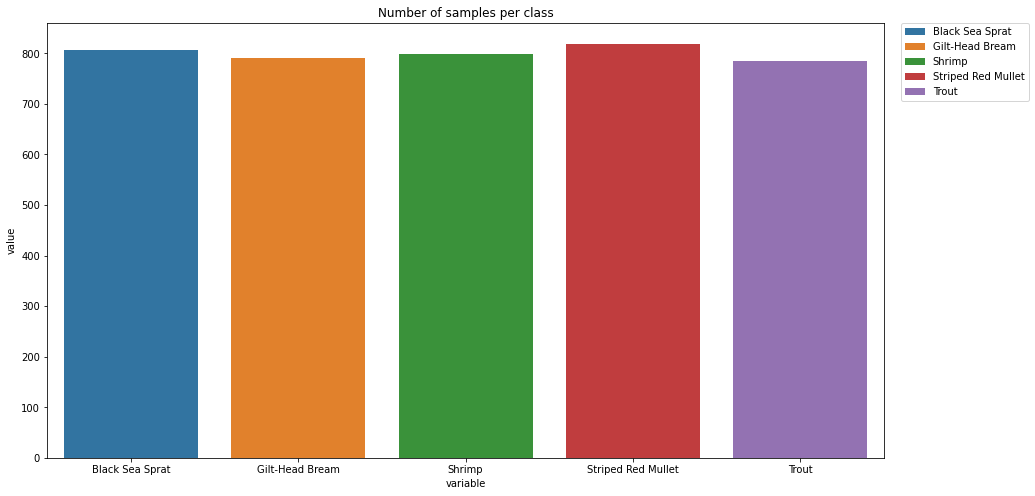

In [80]:
idx2class = {v: k for k, v in dataset.dataset.class_to_idx.items()}

def get_class_distribution(dataset_object):
    count_dict = {k:0 for k,v in dataset.dataset.class_to_idx.items()}

    for element in dataset_object:
        y_lbl = element[1]
        y_lbl = idx2class[y_lbl]
        count_dict[y_lbl] += 1
        
    return count_dict

print(f"Size of training set: {len(dataset.train_subset)}")

# Plot the number of samples per class
plt.figure(figsize=(15,8))

seaborn.barplot(data=pd.DataFrame.from_dict([get_class_distribution(dataset.train_subset)]).melt(), x = "variable", y = "value", hue = "variable", dodge=False).set_title('Number of samples per class')

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

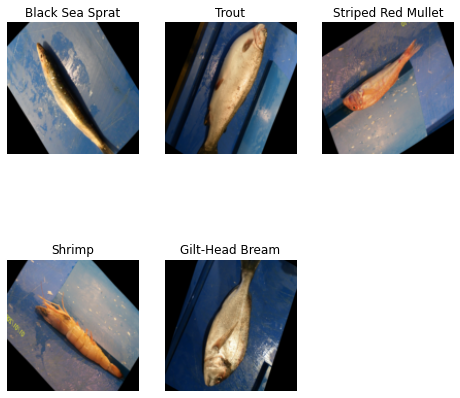

In [5]:

# Plot 1 sample from each of the five classes in the training set
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 2

classes_seen = set()
i = 1

while True:
    # Iterate until a class not displayed is fetch 
    sample_idx = torch.randint(len(dataset.train_subset), size=(1,)).item()
    img, label = dataset.train_subset[sample_idx]
    
    if label not in classes_seen:
        classes_seen.add(label)
        figure.add_subplot(rows, cols, i)
        plt.title(idx2class[label])
        plt.axis("off")
        plt.imshow(img.permute(1, 2, 0), cmap="gray")
        i += 1
    
    if i == 6: break
    
plt.show()

### Step 2.2: Discussion. (10 points)

* Is the dataset balanced?

* Can you think of 3 ways to make the dataset balanced if it is not?

* Is the dataset already pre-processed? If yes, how?

1. The dataset is balanced as there is a similar number of samples for each class.

<p>

2. Three ways to make the dataset balanced:
    - Oversampling:
      - No loss of information and mitigates overfitting caused by oversampling 
      - Higher risk of overfitting 
    - Under-sampling:
      - Run-time can be improved by decreasing the amount of training dataset and helps solve memory problems 
      - Losses some critical information 
    - Cost sensitive learning technique: A form of learning that takes misclassification costs into consideration by minimising the total cost 
      - Advantage of avoiding pre-selection of parameters and auto-adjusts the decision hyperplane 

<p>

3. Preprocessing has already been completed on the dataset:
    - Every image is resized to $590 \times 445$
    - Images are flipped and rotated to produce more samples 

## Step 3: Multiclass classification. (55 points)
In this section we will try to make a multiclass classifier to determine the species of the fish.

### Step 3.1: Define the model. (15 points)

Design a neural network which consists of a number of convolutional layers and a few fully connected ones at the end.

The exact architecture is up to you but you do NOT need to create something complicated. For example, you could design a LeNet insprired network.

In [79]:
class Net(nn.Module):
    def __init__(self, output_dims = 5):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=16,
                               kernel_size=5)

        self.conv2 = nn.Conv2d(in_channels=16,
                               out_channels=32,
                               kernel_size=5)

        self.fc_1 = nn.Linear(32*29*29, 512)
        self.fc_2 = nn.Linear(512, 84)
        self.fc_3 = nn.Linear(84, output_dims)


    def forward(self, x):
        # Forward propagation
        # x = [batch size, 3, 128, 128]
        x = self.conv1(x)

        # x = [batch size, 16, 124, 124]
        x = F.max_pool2d(x, kernel_size=2)

        # x = [batch size, 16, 62, 62]
        x = F.relu(x)
        x = self.conv2(x)
        
        # x = [batch size, 32, 58, 58]
        x = F.max_pool2d(x, kernel_size=2)
        
        # x = [batch size, 32, 29, 29]
        x = F.relu(x)
        x = x.view(x.shape[0], -1)
        
        # x = [batch size, 32*29*29 = 26912]
        x = self.fc_1(x)
        
        # x = [batch size, 512]
        x = F.relu(x)
        x = self.fc_2(x)

        # x = batch size, 84]
        x = F.relu(x)
        x = self.fc_3(x)

        # x = [batch size, output dim]
        return x

# Since most of you use laptops, you may use CPU for training.
# If you have a good GPU, you can set this to 'gpu'.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Step 3.2: Define the training parameters. (10 points)

- Loss function
- Optimizer
- Learning Rate
- Number of iterations
- Batch Size
- Other relevant hyperparameters

In [37]:
# Network
model = Net()

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimiser and learning rate
lr = 0.001
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

# Number of iterations for training
epochs = 15

# Training batch size
train_batch_size = 20

# Based on the FishDataset, use the PyTorch DataLoader to load the data during model training
train_dataloader = DataLoader(dataset=dataset.train_subset, batch_size=train_batch_size, shuffle=True)
test_dataloader = DataLoader(dataset=dataset.test_subset, batch_size=train_batch_size, shuffle=False)

### Step 3.3: Train the model. (15 points)

Complete the training loop.

In [38]:
for epoch in tqdm(range(epochs)):
    model.train()
    loss_curve = []
    running_loss = 0
    
    for i, data in enumerate(train_dataloader, 0):
        # Get a batch of training data and train the model
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        loss_curve.append(loss.item())
        running_loss += loss.item()
        
    print('--- Iteration {0}: training loss = {1:.4f} ---'.format(epoch + 1, np.array(loss_curve).mean()))

  7%|▋         | 1/15 [01:24<19:48, 84.89s/it]

--- Iteration 1: training loss = 1.5722 ---


 13%|█▎        | 2/15 [02:48<18:15, 84.30s/it]

--- Iteration 2: training loss = 1.2128 ---


 20%|██        | 3/15 [04:14<16:57, 84.78s/it]

--- Iteration 3: training loss = 0.9479 ---


 27%|██▋       | 4/15 [05:37<15:27, 84.32s/it]

--- Iteration 4: training loss = 0.6887 ---


 33%|███▎      | 5/15 [07:00<13:58, 83.87s/it]

--- Iteration 5: training loss = 0.5339 ---


 40%|████      | 6/15 [08:23<12:30, 83.37s/it]

--- Iteration 6: training loss = 0.3995 ---


 47%|████▋     | 7/15 [09:46<11:06, 83.29s/it]

--- Iteration 7: training loss = 0.2743 ---


 53%|█████▎    | 8/15 [11:08<09:39, 82.78s/it]

--- Iteration 8: training loss = 0.1923 ---


 60%|██████    | 9/15 [12:31<08:17, 82.86s/it]

--- Iteration 9: training loss = 0.1567 ---


 67%|██████▋   | 10/15 [13:55<06:57, 83.41s/it]

--- Iteration 10: training loss = 0.1592 ---


 73%|███████▎  | 11/15 [15:21<05:36, 84.22s/it]

--- Iteration 11: training loss = 0.0902 ---


 80%|████████  | 12/15 [16:45<04:12, 84.07s/it]

--- Iteration 12: training loss = 0.1056 ---


 87%|████████▋ | 13/15 [18:09<02:48, 84.09s/it]

--- Iteration 13: training loss = 0.0498 ---


 93%|█████████▎| 14/15 [19:34<01:24, 84.45s/it]

--- Iteration 14: training loss = 0.0785 ---


100%|██████████| 15/15 [21:00<00:00, 84.04s/it]

--- Iteration 15: training loss = 0.0438 ---


### Step 3.4: Deploy the trained model onto the test set. (10 points)

In [40]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Black Sea Sprat is 99.5 %
Accuracy for class: Gilt-Head Bream is 98.1 %
Accuracy for class: Shrimp is 96.0 %
Accuracy for class: Striped Red Mullet is 96.1 %
Accuracy for class: Trout is 99.1 %


### Step 3.5: Evaluate the performance of the model and visualize the confusion matrix. (5 points)

You can use sklearns related function.

Model classification report 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       193
           1       0.98      0.98      0.98       209
           2       0.98      0.96      0.97       201
           3       0.95      0.96      0.95       181
           4       0.99      0.99      0.99       216

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



<AxesSubplot:>

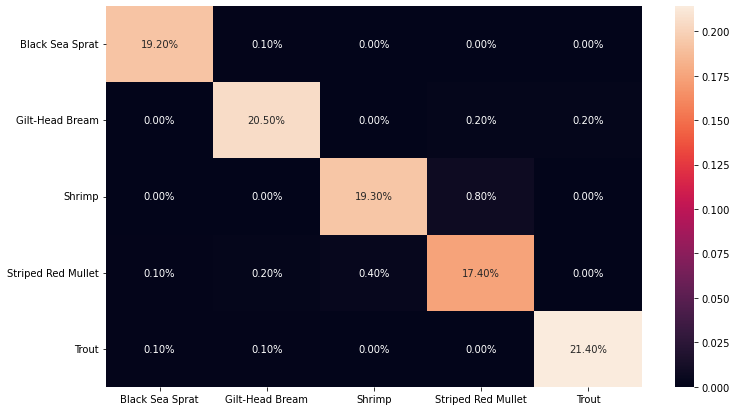

In [41]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

y_pred = []
y_true = []

# again no gradients needed
with torch.no_grad():
    for data in test_dataloader:
        inputs, labels = data
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)
        
        # Confusion matrix
        output = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        cm_labels = labels.data.cpu().numpy()
        y_true.extend(cm_labels) # Save Truth
        
        # collect the correct predictions for each class
        for labels, prediction in zip(labels, predictions):
            if labels == prediction:
                correct_pred[classes[labels]] += 1
            total_pred[classes[labels]] += 1

# Print sklearn classification report
print("Model classification report \n {}".format(classification_report(y_true, y_pred)))
    
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
seaborn.heatmap(df_cm, annot=True, fmt='.2%')

## Step 4: Finetune your classifier. (15 points)

In the previous section, you have built a pretty good classifier for certain species of fish. Now we are going to use this trained classifier and adapt it to classify a new set of species:

    'Hourse Mackerel
    'Red Mullet',
    'Red Sea Bream'
    'Sea Bass'

### Step 4.1: Set up the data for new species. (2 points)
Overwrite the labels correspondances so they only incude the new classes and regenerate the datasets and dataloaders.

In [66]:
Multiclass_labels_correspondances ={
    'Hourse Mackerel': 0,
    'Red Mullet': 1,
    'Red Sea Bream': 2,
    'Sea Bass': 3}

LENDATA = 4000
idxs_train,idxs_test = split_train_test(LENDATA, 0.8)

# Dataloaders
# Training set
img_path = './Task_2_Dataset'
transform_extra = transforms.Compose(
    [transforms.Resize(size=(128, 128)), 
     transforms.ToTensor()]
)

task_2_dataset = FishDataset(img_path, idxs_train, idxs_test, transform_extra, train=True)

# Dataloaders 
# Based on the FishDataset, use the PyTorch DataLoader to load the data during model training
task_2_train_dataloader = DataLoader(dataset=task_2_dataset.train_subset, batch_size=train_batch_size, shuffle=True)
task_2_test_dataloader = DataLoader(dataset=task_2_dataset.test_subset, batch_size=train_batch_size, shuffle=False)

idx2class = {v: k for k, v in task_2_dataset.dataset.class_to_idx.items()}

task_2_classes = ('Hourse Mackerel', 'Red Mullet', 'Red Sea Bream', 'Sea Bass')


### Step 4.2: Freeze the weights of all previous layers of the network except the last layer. (5 points)

You can freeze them by setting the gradient requirements to ```False```.

In [67]:
def freeze_till_last(model):
    for name, param in model.named_parameters():
        # param.requires_grad = False
        if param.requires_grad and 'fc_3' not in name:
            param.requires_grad = False

def show_frozen_layers(model):
    for name, param in model.named_parameters():
        if param.requires_grad: print(name)

freeze_till_last(model)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimiser and learning rate
lr = 0.001
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

# Number of iterations for training
epochs = 15

# Training batch size
train_batch_size = 20


### Step 4.3: Train and test your finetuned model. (5 points)

In [75]:
# Finetune the model
for epoch in tqdm(range(epochs)):
    model.train()
    loss_curve = []
    running_loss = 0
    
    for i, data in enumerate(task_2_train_dataloader, 0):
        # Get a batch of training data and train the model
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        loss_curve.append(loss.item())
        running_loss += loss.item()
        
    print('--- Iteration {0}: training loss = {1:.4f} ---'.format(epoch + 1, np.array(loss_curve).mean()))


  7%|▋         | 1/15 [00:52<12:20, 52.90s/it]

--- Iteration 1: training loss = 0.6795 ---


 13%|█▎        | 2/15 [01:43<11:08, 51.43s/it]

--- Iteration 2: training loss = 0.6687 ---


 20%|██        | 3/15 [02:33<10:12, 51.05s/it]

--- Iteration 3: training loss = 0.6671 ---


 27%|██▋       | 4/15 [03:24<09:18, 50.75s/it]

--- Iteration 4: training loss = 0.6351 ---


 33%|███▎      | 5/15 [04:14<08:26, 50.70s/it]

--- Iteration 5: training loss = 0.6138 ---


 40%|████      | 6/15 [05:08<07:44, 51.58s/it]

--- Iteration 6: training loss = 0.6197 ---


 47%|████▋     | 7/15 [05:58<06:49, 51.24s/it]

--- Iteration 7: training loss = 0.5946 ---


 53%|█████▎    | 8/15 [06:50<06:00, 51.45s/it]

--- Iteration 8: training loss = 0.5914 ---


 60%|██████    | 9/15 [07:41<05:07, 51.24s/it]

--- Iteration 9: training loss = 0.5858 ---


 67%|██████▋   | 10/15 [08:30<04:12, 50.59s/it]

--- Iteration 10: training loss = 0.5782 ---


 73%|███████▎  | 11/15 [09:22<03:24, 51.04s/it]

--- Iteration 11: training loss = 0.5780 ---


 80%|████████  | 12/15 [10:15<02:34, 51.66s/it]

--- Iteration 12: training loss = 0.5737 ---


 87%|████████▋ | 13/15 [11:08<01:43, 51.90s/it]

--- Iteration 13: training loss = 0.5774 ---


 93%|█████████▎| 14/15 [11:58<00:51, 51.61s/it]

--- Iteration 14: training loss = 0.5572 ---


100%|██████████| 15/15 [12:50<00:00, 51.34s/it]

--- Iteration 15: training loss = 0.5634 ---


Model classification report 
               precision    recall  f1-score   support

           0       0.73      0.78      0.75       217
           1       0.88      0.79      0.83       178
           2       0.85      0.93      0.89       214
           3       0.75      0.68      0.71       191

    accuracy                           0.80       800
   macro avg       0.80      0.79      0.80       800
weighted avg       0.80      0.80      0.80       800



<AxesSubplot:>

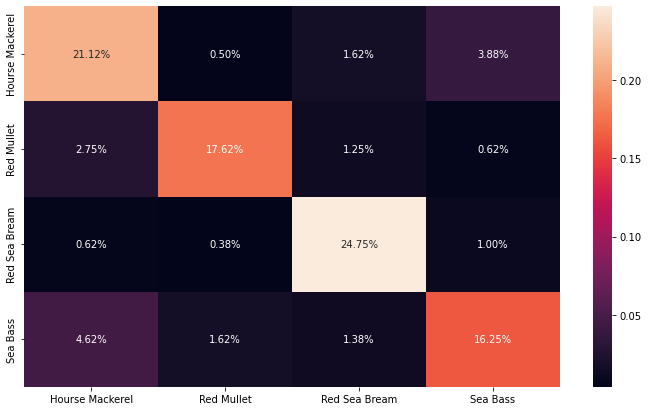

In [76]:

# Deploy the model on the test set
# Evaluate the performance
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in task_2_classes}
total_pred = {classname: 0 for classname in task_2_classes}

y_pred = []
y_true = []

with torch.no_grad():
    for data in task_2_test_dataloader:
        inputs, labels = data
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)
        
        # Confusion matrix
        output = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        cm_labels = labels.data.cpu().numpy()
        y_true.extend(cm_labels) # Save Truth
        
        # collect the correct predictions for each class
        for labels, prediction in zip(labels, predictions):
            if labels == prediction:
                correct_pred[task_2_classes[labels]] += 1
            total_pred[task_2_classes[labels]] += 1

# Print sklearn classification report
print("Model classification report \n {}".format(classification_report(y_true, y_pred)))
    
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix), index = [i for i in task_2_classes],
                     columns = [i for i in task_2_classes])
plt.figure(figsize = (12,7))
seaborn.heatmap(df_cm, annot=True, fmt='.2%')

### Step 4.4: Did finetuning work? Why did we freeze the first few layers? (3 points)

- Fine tuning did not work in this situation as the accuracy for the new classes fell short of the average accuracy of the previous classes. This is possibly due to the new dataset not being similar to the original dataset that the model trained all the layers on. While the there is a reduction in training time i.e. 12 minute compared to 23 minute since we are only optimizing in a subset of the feature space, by only updating the last layer, the model could not reach suitable levels of accuracy compared to the previous dataset. 

  There are several possible solutions to this problem:
  - Train for larger number of epochs 
  - Adjusting the learning rates
  - A solution would be to unfreezing everything will allow you to optimize in the whole feature space, allowing you to find better optima.

<par>

- Using a trained classifier and adapting it to classify a new set of species is *transfer learning* where we are taking features learned on one problem and leveraging them on a new, similar problem.

    While freezing layers are not required in transfer learning, freezing layers offers several advantages:
    - Faster to train since the gradient has less components 
    - Require less data to train on  